In [200]:
%matplotlib inline
import backtrader as bt
import requests
import pandas as pd
# import talib

In [201]:
def fetch_binance_candle_data(startTime,limit=1000):
    url = 'https://api.binance.com/api/v3/klines'
    # Set the parameters
    params = {
        'symbol': 'BTCUSDT',  # Symbol for Ethereum/Tether
        'interval': '4h',     # Interval: 1 day
        'limit': limit,          # Number of data points to retrieve
        "startTime":startTime, #2021.1.1
        # "endTime":END_DATE,
        "timeZone":"+0:00"
    }
    # Make the GET request
    response = requests.get(url, params=params)
    data = response.json()
    
    # Binance returns a list of lists. Each inner list represents a candle:
    # [open_time, open, high, low, close, volume, close_time, ...]
    df = pd.DataFrame(data, columns=[
        "open_time", "open", "high", "low", "close", "volume", 
        "close_time", "quote_asset_volume", "num_trades", 
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # Convert 'close' to numeric
    df['open_time'] = pd.to_numeric(df['open_time'])
    df['close_time'] = pd.to_numeric(df['open_time'])
    
    
    # Convert timestamps to datetime (milliseconds to UTC)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms', utc=True)
    
    # Convert 'close' price to numeric (this will serve as our sell price)
    df['open'] = pd.to_numeric(df['open'])
    df['close'] = pd.to_numeric(df['close'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['volume'] = pd.to_numeric(df['volume'])
    
    # We will use the candle's closing time as the reference time
    df = df[['close_time', 'open','close', 'high', 'low',"volume"]]
    df.rename(columns={
        "close_time": "dateTime",
        }, inplace=True)
    
    return df



## 策略

In [202]:

class MyStrategy(bt.Strategy):
    params = (('ma_period', 5), ('mfi_period', 5), ('mfi_delta_threshold', 10),('sma_mfi_delta_period', 3))

    def __init__(self):
        self.ma = bt.indicators.MovingAverageSimple(self.data.close, period=self.params.ma_period,plot=False)
        # self.mfi = bt.talib.MFI(self.data.high,self.data.low,self.data.close,self.data.volume, timeperiod=self.params.mfi_period,plot=False)
        
        self.mfi = bt.talib.RSI(self.data.close, timeperiod=self.params.mfi_period,plot=False)  # Using RSI as a placeholder for MFI
        
        self.mfi_delta = self.mfi - self.mfi(-1)
        self.mfi_delta_sma = bt.indicators.SMA(self.mfi_delta, period=self.params.sma_mfi_delta_period,plot=False)
        self.trades = []  # List to track open trades
        self.trade_sizes = {}  # Dictionary to track trade sizes by reference
        
    def next(self):
        # print("Info: ", self.ma[0], self.mfi[0], self.mfi_delta[0], self.mfi_delta_sma[0])
        if not self.position:
            if self.data.close[0] < self.ma[0] and self.mfi_delta_sma[0] < 0:
                self.sell() #Short
                # print("Short")
            elif self.data.close[0] > self.ma[0] and self.mfi_delta_sma[0] > 0:
                self.buy() #Long
                # print("Long")
        else:
            # Finish Short
            if self.position.size < 0 and self.mfi_delta[0] > self.params.mfi_delta_threshold:
                self.close()
                # print("Close Short")
            # Finish Long
            elif self.position.size > 0 and self.mfi_delta[0] < self.params.mfi_delta_threshold:
                self.close()
                # print("Close Long")

    def notify_trade(self, trade):
        if not trade.isclosed:
            self.trade_sizes[trade.ref] = trade.size
            # print(f"Trade Open - Ref: {trade.ref}, Size: {trade.size}")
        else:
            size = self.trade_sizes.get(trade.ref, trade.size)
            if size != 0:
                exit_price = trade.price + trade.pnl / size
                trade_details = {
                    'date': self.data.datetime.datetime(0),
                    'type': 'Long' if trade.long else 'Short',
                    'entry_price': trade.price,
                    'exit_price': exit_price,
                    'size': size,
                    'pnl': trade.pnl,
                    'commission': trade.commission
                }
                self.trades.append(trade_details)
                # print(f"Trade Added: {trade_details}")
            else:
                pass
                # print(f"Weird - Zero Size Trade Closed, PnL: {trade.pnl}")
            if trade.ref in self.trade_sizes:
                del self.trade_sizes[trade.ref]

## 系統設定

In [203]:
def run_backtrace(data_df,_ma_period=5, _mfi_period=5, _mfi_delta_threshold=10,_sma_mfi_delta_period=3,_funding_rate=25,_cheat_on_open=False,_tann=2190):
    # Setup and run
    cerebro = bt.Cerebro(cheat_on_open=_cheat_on_open)  # Allow cheat on close to close positions at the end of the day
    # 系統設定
    cerebro.broker.setcommission(commission=0.0005) #5bp
    cerebro.broker.setcash(10000)  # Start with $10,000
    # Data feed部分
    data = bt.feeds.PandasData(dataname=data_df, datetime='dateTime',timeframe=bt.TimeFrame.Minutes,compression=240, openinterest=None)                  
    cerebro.adddata(data)
    cerebro.addstrategy(MyStrategy,ma_period=_ma_period, mfi_period=_mfi_period, sma_mfi_delta_period =_sma_mfi_delta_period ,mfi_delta_threshold=_mfi_delta_threshold)
    
    #設定起始資金
    cerebro.broker.set_cash(10000)  
    
    # 分析metrics
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe',timeframe=bt.TimeFrame.Minutes,compression=240)
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns',timeframe=bt.TimeFrame.Minutes, compression=240, tann=_tann)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    
    # 預算控制
    cerebro.addsizer(bt.sizers.PercentSizer, percents=_funding_rate)  
    
    #用來畫DD圖
    cerebro.addobserver(bt.observers.DrawDown)
    
    
    # Run backtest
    results = cerebro.run()
    strat = results[0]  # First strategy instance
    
    # 評估Metric
    sharpe = strat.analyzers.sharpe.get_analysis()['sharperatio']  
    total_return_metrics = strat.analyzers.returns.get_analysis()  
    max_mdd = strat.analyzers.drawdown.get_analysis()['max']['drawdown']  # MDD
    
    
    # Specific returns from Returns analyzer
    total_return = total_return_metrics['rtot']  # 1000根bar的總報酬率
    annualized_return = total_return_metrics['rnorm100']  # 換算成年化報酬率
    
    
    # Get initial cash and final value
    initial_cash = cerebro.broker.startingcash  # $10,000
    final_value = cerebro.broker.getvalue()     # Final portfolio value
    net_profit = final_value - initial_cash     # Net profit in dollars
    

    return {
        'cerebro': cerebro,
        "sharpe":sharpe,
        "annualized_return":annualized_return,
        "total_return":total_return,
        "max_mdd":max_mdd,
        "net_profit":net_profit,
        "trades":strat.trades,
        }




In [204]:
data_df = fetch_binance_candle_data(1609455600000,limit=1000)


## 類Grid Search部分

In [205]:
# 參數搜尋範圍設定
ma_periods = [2, 5, 10, 15, 20, 25, 30, 35, 40]
mfi_delta_thresholds = list(range(2, 20,3))
mfi_periods = list(range(4, 20,3))
sma_mfi_delta_periods= [2] #當作常數
# Grid Search：遍歷所有參數組合，並記錄績效指標
results = []
funding_rate = 100 # 50%資金進場
for ma_period in ma_periods:
    for mfi_delta_threshold in mfi_delta_thresholds:
        for mfi_period in mfi_periods:
            for smi_mfi_delta_period in sma_mfi_delta_periods:
                # 計算績效指標
                metrics = run_backtrace(data_df, ma_period, mfi_period, mfi_delta_threshold,smi_mfi_delta_period,_funding_rate=funding_rate, _cheat_on_open=False)
                if metrics is None:
                    continue
                results.append({
                    'ma_period': ma_period,
                    'mfi_delta_threshold': mfi_delta_threshold,
                    'mfi_period': mfi_period,
                    'smi_mfi_delta_period': smi_mfi_delta_period,
                    'sharpe': metrics['sharpe'],
                    'annualized_return': metrics['annualized_return'],
                    'total_return': metrics['total_return'],
                    'max_mdd': metrics['max_mdd'],
                    'net_profit': metrics['net_profit']
                })


In [206]:
# 將結果轉換為 DataFrame 以便於分析、並清理一下
results_df = pd.DataFrame(results)
results_df.describe()  # 總覽

,ma_period,mfi_delta_threshold,mfi_period,smi_mfi_delta_period,sharpe,annualized_return,total_return,max_mdd,net_profit
count,324.000000,324.0000,324.0000,324.0,324.000000,324.000000,324.000000,324.000000,324.000000
mean,20.222222,9.5000,11.5000,2.0,-0.606605,-30.736212,-0.259949,50.755307,-1957.440871
std,12.596132,5.1314,5.1314,0.0,0.231291,47.093029,0.289410,19.872730,2390.502328
min,2.000000,2.0000,4.0000,2.0,-0.971903,-88.187040,-0.975330,18.879463,-6229.321424
25%,10.000000,5.0000,7.0000,2.0,-0.784929,-63.760113,-0.463483,34.705458,-3709.088201
50%,20.000000,9.5000,11.5000,2.0,-0.589475,-45.746251,-0.279223,50.243107,-2436.286865
75%,30.000000,14.0000,16.0000,2.0,-0.497362,-9.840134,-0.047301,61.634078,-461.989099
max,40.000000,17.0000,19.0000,2.0,0.022241,148.874238,0.416337,106.666592,5163.964510


In [207]:
def normalize_series(series):
    """利用 z-score normalization 將 series 標準化為均值0、標準差1"""
    mean_val = series.mean()
    std_val = series.std()
    if std_val == 0:  # 避免除以0的情況
        return series - mean_val
    return (series - mean_val) / std_val

In [208]:
# 先對各指標進行標準化
results_df['norm_sharpe'] = normalize_series(results_df['sharpe'])
results_df['norm_total_return'] = normalize_series(results_df['total_return'])
# # 對最大回撤，因數值越低越好，所以先正規化再取反
results_df['norm_max_drawdown_raw'] = normalize_series(results_df['max_mdd'])
results_df['norm_max_drawdown'] = -results_df['norm_max_drawdown_raw']
# 淨利
results_df['norm_net_profit'] =normalize_series(results_df['net_profit']) 



# 建立綜合評分函數：分數 = norm_sharpe + norm_total_return + norm_max_drawdown
results_df['composite_score'] = (results_df['norm_sharpe']*1.5 +
                                 results_df['norm_net_profit']*1.5 +
                                 results_df['norm_max_drawdown']*1)

# 找出最佳參數組合（最好排到最爛）
best_params = []
results_df_sorted = results_df.sort_values(by='composite_score', ascending=False).head()
for i in range(0, 1):
    print(results_df_sorted.iloc[i])
    best_params.append(results_df_sorted.iloc[i])

ma_period                  35.000000
mfi_delta_threshold        14.000000
mfi_period                  7.000000
smi_mfi_delta_period        2.000000
sharpe                     -0.611782
annualized_return         148.874238
total_return                0.416337
max_mdd                    25.215438
net_profit               5163.964510
norm_sharpe                -0.022384
norm_total_return           2.336779
norm_max_drawdown_raw      -1.285172
norm_max_drawdown           1.285172
norm_net_profit             2.979041
composite_score             5.720157
Name: 277, dtype: float64


## 用最好Parameter去跑
用來畫圖

In [209]:
test_result = run_backtrace(data_df,
                           _ma_period=int(best_params[0]['ma_period']),
                           _mfi_period=int(best_params[0]['mfi_period']),
                           _funding_rate=100,
                           _mfi_delta_threshold=int(best_params[0]['mfi_delta_threshold']),
                           _tann=2190,
                           _cheat_on_open=False)
print("Final Result:")
print("Sharpe Ratio:",test_result['sharpe'])
print("Annualized Return:",test_result['annualized_return'])
print("Total Return:",test_result['total_return'])
print("Max Drawdown:",test_result['max_mdd'])
print("Net Profit:",test_result['net_profit'])


Final Result:
Sharpe Ratio: -0.6178654616524035
Annualized Return: 147.47916624283044
Total Return: 0.41376996149814776
Max Drawdown: 25.215438204505006
Net Profit: 5125.091515228096


In [210]:
test_trades_detail= pd.DataFrame(test_result['trades'])
test_trades_detail.to_csv("trades_detail.csv",index=False) #儲存交易紀錄

<IPython.core.display.Javascript object>

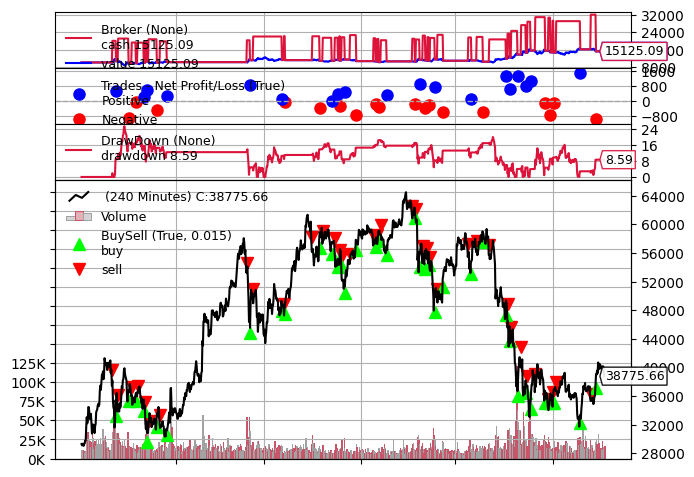

In [211]:
test_result['cerebro'].plot()[0][0]

## Validation部分

In [212]:
# Validation 2021.08.01 ~ 2022.03.05
df_validation_1 = fetch_binance_candle_data(1627768800000)
df_validation_2 = fetch_binance_candle_data(1642158000000,limit=300)
df_validation_2.drop(df_validation_2.index[0], inplace=True)
df_validation = pd.concat([df_validation_1,df_validation_2],axis=0)

val_result = run_backtrace(df_validation,
                           _ma_period=int(best_params[0]['ma_period']),
                           _mfi_period=int(best_params[0]['mfi_period']),
                           _funding_rate=100,
                           _mfi_delta_threshold=int(best_params[0]['mfi_delta_threshold']),
                           _tann=2190,
                           _cheat_on_open=False)


print("Validation Result:")
print("Sharpe Ratio:", val_result['sharpe'])
print("Annualized Return:", val_result['annualized_return'])
print("Total Return:", val_result['total_return'])
print("Max Drawdown:", val_result['max_mdd'])
print("Net Profit:", val_result['net_profit'])

Validation Result:
Sharpe Ratio: -1.0004563367773833
Annualized Return: -24.078585618092678
Total Return: -0.16339605075237537
Max Drawdown: 31.09423655592808
Net Profit: -1507.4522619176641


<IPython.core.display.Javascript object>

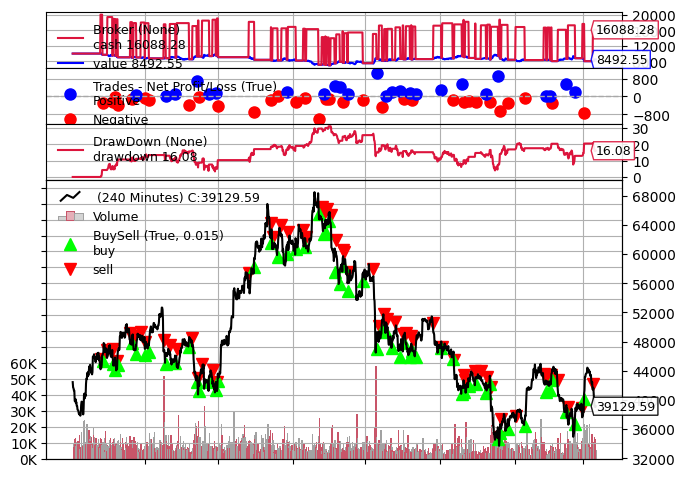

In [213]:
val_result['cerebro'].plot()[0][0]

<IPython.core.display.Javascript object>

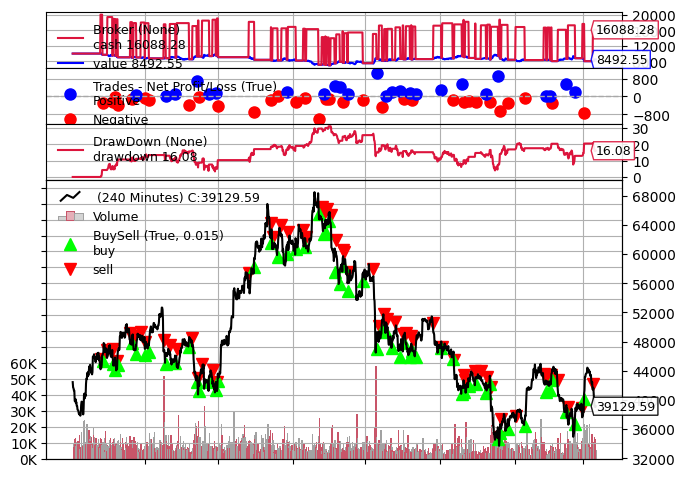

In [214]:
val_result['cerebro'].plot()[0][0]